In [85]:
import os
from sam import chdir_to_repopath
chdir_to_repopath()
from sam.dose_reponse_fit import dose_response_fit, ModelPredictions, survival_to_stress, FitSettings, Transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sam.data_formats import read_data, load_files, load_datapoints
from sam.plotting import plot_fit_prediction
from sam.system_stress import pred_surv_without_hormesis
from sam.helpers import detect_hormesis_index, pad_c0, compute_lc_from_curve, weibull_2param, weibull_2param_inverse, compute_lc, ll5_inv
from sam.data_formats import ExperimentData
from scipy.optimize import brentq
import seaborn as sns
from sam.stress_addition_model import OLD_STANDARD, sam_prediction, get_sam_lcs

In [86]:
dfs = []

for path, data, stress_name, stress_series in load_datapoints():

    meta = data.meta

    main_fit, stress_fit, sam_sur, sam_stress, additional_stress = sam_prediction(
        data.main_series,
        stress_series,
        data.meta,
        settings=OLD_STANDARD,
    )

    lcs = get_sam_lcs(stress_fit=stress_fit, sam_sur=sam_sur, meta=data.meta)
    
    main_lc10 = compute_lc(optim_param=main_fit.optim_param, lc=10)
    main_lc50 = compute_lc(optim_param=main_fit.optim_param, lc=50)

    dfs.append(
        {
            "title": path[:-4],
            "chemical": meta.chemical,
            "organism": meta.organism,
            "main_fit": main_fit,
            "stress_fit": stress_fit,
            "stress_name": stress_name,
            "main_lc10":main_lc10,
            "main_lc50":main_lc50,
            "stress_lc10" : lcs.stress_lc10,
            "stress_lc50" : lcs.stress_lc50,
            "sam_lc10" : lcs.sam_lc10,
            "sam_lc50" : lcs.sam_lc50,
        }
    )

df = pd.DataFrame(dfs)
df.head()

,title,chemical,organism,main_fit,stress_fit,stress_name,main_lc10,main_lc50,stress_lc10,stress_lc50,sam_lc10,sam_lc50
0,/home/felix/Desktop/sam/data/huang_Flupyradifu...,Flupyradifurone,Gammarus pulex,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Temp_15,12.103473,24.217719,2.769817,16.013050,4.998847,13.643113
1,/home/felix/Desktop/sam/data/naeem_Esfenvalera...,Esfenvalerate,Daphnia magna,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Prochloraz_1,0.034669,0.435088,0.076167,0.550485,0.034712,0.435554
2,/home/felix/Desktop/sam/data/naeem_Esfenvalera...,Esfenvalerate,Daphnia magna,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Prochloraz_32,0.034669,0.435088,0.024155,0.185064,0.000886,0.079306
3,/home/felix/Desktop/sam/data/naeem_Esfenvalera...,Esfenvalerate,Daphnia magna,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Prochloraz_100,0.034669,0.435088,0.005580,0.152430,0.000886,0.079306
4,/home/felix/Desktop/sam/data/naeem_Esfenvalera...,Esfenvalerate,Daphnia magna,ModelPredictions(concentration_curve=array([1....,ModelPredictions(concentration_curve=array([1....,Food_1%,0.034669,0.435088,0.000269,0.040317,0.000291,0.046408


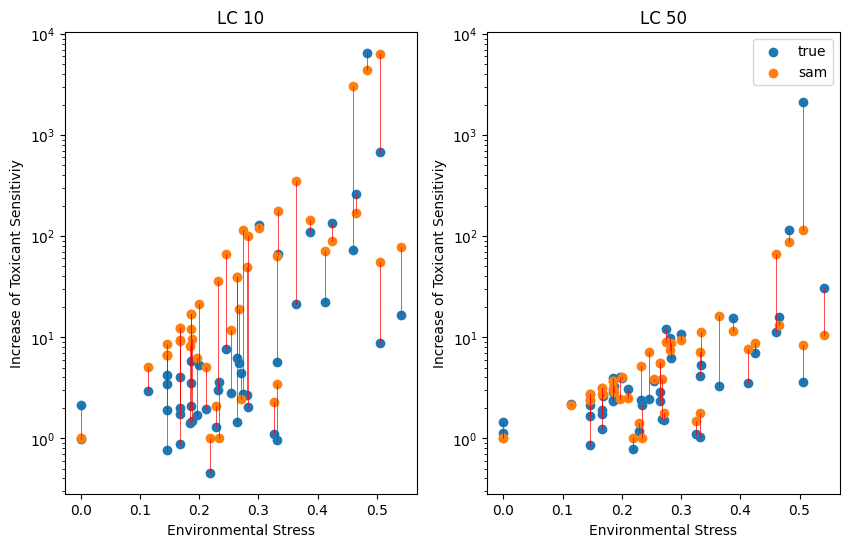

In [101]:
df["true_10_frac"] = df.main_lc10 / df.stress_lc10
df["true_50_frac"] = df.main_lc50 / df.stress_lc50
df["sam_10_frac"] = df.main_lc10 / df.sam_lc10
df["sam_50_frac"] = df.main_lc50 / df.sam_lc50

df["stress_level"] = df.stress_fit.apply(lambda x: survival_to_stress(x.optim_param["d"]))


y_name = "Increase of Toxicant Sensitiviy"
x_name = "Environmental Stress"


def subplot(true_col, sam_col):

    plt.scatter(df.stress_level, df[true_col], label = "true")
    plt.scatter(df.stress_level, df[sam_col], label = "sam")


    for i in range(len(df)):
        plt.plot(
            [df.stress_level[i], df.stress_level[i]],
            [df[true_col][i], df[sam_col][i]],
            color='red',
            linewidth=0.5
        )

    plt.yscale("log")
    plt.xlabel(x_name)
    plt.ylabel(y_name)

plt.figure(figsize=(10,6))
ax1 = plt.subplot(1,2,1)
plt.title("LC 10")
subplot("true_10_frac", "sam_10_frac")

plt.subplot(1,2,2, sharey = ax1)
plt.title("LC 50")
subplot("true_50_frac", "sam_50_frac")

plt.legend()
plt.show()

In [ ]:
df["true_10_frac"] = df.main_lc10 / df.stress_lc10
df["true_50_frac"] = df.main_lc50 / df.stress_lc50
df["sam_10_frac"] = df.main_lc10 / df.sam_lc10
df["sam_50_frac"] = df.main_lc50 / df.sam_lc50

df["stress_level"] = df.stress_fit.apply(lambda x: survival_to_stress(x.optim_param["d"]))


y_name = "Increase of Toxicant Sensitiviy"
x_name = "Environmental Stress"


def subplot(true_col, sam_col):

    plt.scatter(df[true_col], df[sam_col], label = "true")

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Measured Increase of Toxicant Sensitiviy")
    plt.ylabel("Predicted Increase of Toxicant Sensitiviy")

plt.figure(figsize=(10,6))
ax1 = plt.subplot(1,2,1)
plt.title("LC 10")
subplot("true_10_frac", "sam_10_frac")

plt.subplot(1,2,2, sharey = ax1)
plt.title("LC 50")
subplot("true_50_frac", "sam_50_frac")

plt.legend()
plt.show()

In [ ]:


plot_frame = df[["stress_level", "10_frac", "50_frac"]].melt(id_vars = "stress_level", value_vars = ["10_frac", "50_frac"], var_name = "LC", value_name = y_name)
plot_frame.LC = plot_frame.LC.str.replace("_frac", "")
plot_frame = plot_frame.rename(columns={"stress_level": x_name})


g = sns.FacetGrid(plot_frame, hue = "LC",  height=6, aspect=1.5)
g.map(sns.scatterplot, x_name, y_name, )
g.set(yscale="log")
g.add_legend()
plt.show()